<a href="https://colab.research.google.com/github/BerkAIcelik/leishmania-detecting/blob/main/Leishmania_model_script.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **MODEL** **SCRIPT**

<ipython-input-3-fb27429b68c0>:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/content/drive/MyDrive/4_Dataset.pth', map_location=torch.

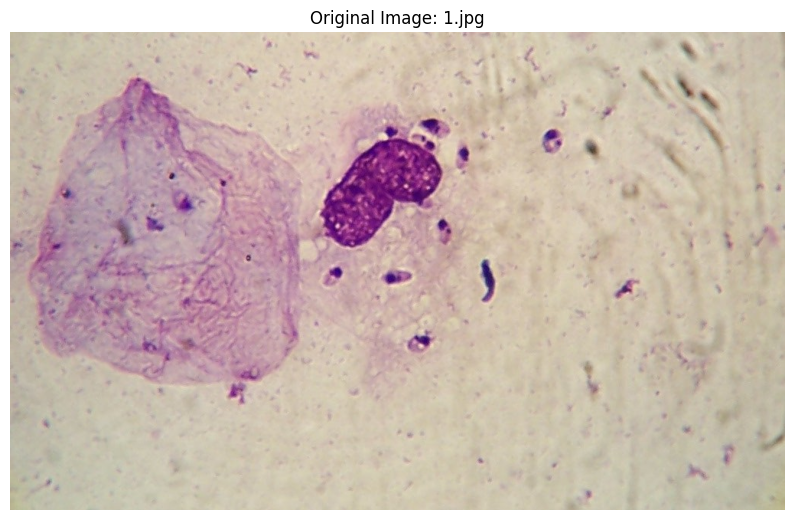

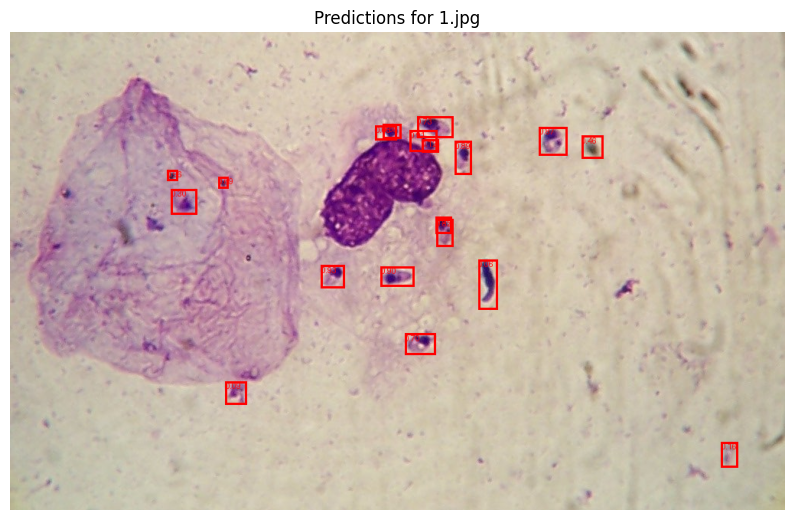

In [3]:
import os
import torch
from torchvision import transforms
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
import torchvision.models.detection as detection
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# Modeli yeniden tanımlama ve ağırlıkları yükleme
def get_model(num_classes):
    model = detection.fasterrcnn_resnet50_fpn(weights=detection.FasterRCNN_ResNet50_FPN_Weights.DEFAULT)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

# Sınıf sayısı (arka plan dahil)
num_classes = 2

# Modeli yükleme
model = get_model(num_classes)
model.load_state_dict(torch.load('/content/drive/MyDrive/4_Dataset.pth', map_location=torch.device('cpu')))
model.eval()  # Modeli değerlendirme moduna alın

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model = model.to(device)

# Görüntü işleme adımları
transform = transforms.Compose([
    transforms.ToTensor(),
])

# Görüntüyü yükleyin ve işleyin
def load_and_process_image(img_path):
    input_image = Image.open(img_path).convert("RGB")
    input_tensor = transform(input_image)
    input_batch = input_tensor.unsqueeze(0)  # Modelin beklediği şekle getirin
    return input_batch, input_image

# Görüntüleri test etmek için bir betik
def test_image(img_path, model):
    # Görüntüyü yükleme ve işleme
    input_batch, input_image = load_and_process_image(img_path)
    input_batch = input_batch.to(device)

    # Orijinal görüntüyü göster
    plt.figure(figsize=(10, 10))
    plt.imshow(input_image)
    plt.title(f'Original Image: {os.path.basename(img_path)}')
    plt.axis('off')
    plt.show()

    # Tahmin yapın
    with torch.no_grad():
        output = model(input_batch)

    # Çıktıları işleme
    predicted_boxes = output[0]['boxes'].cpu().numpy()
    predicted_scores = output[0]['scores'].cpu().numpy()
    predicted_labels = output[0]['labels'].cpu().numpy()

    # Tahmin edilen kutularla görüntüyü çizdirme
    image_pil_with_boxes = input_image.copy()
    draw = ImageDraw.Draw(image_pil_with_boxes)

    for box, score, label in zip(predicted_boxes, predicted_scores, predicted_labels):
        draw.rectangle(box.tolist(), outline="red", width=3)
        draw.text((box[0], box[1]), f"{score:.2f}", fill="red")

    # İşaretli görüntüyü göster
    plt.figure(figsize=(10, 10))
    plt.imshow(image_pil_with_boxes)
    plt.title(f'Predictions for {os.path.basename(img_path)}')
    plt.axis('off')
    plt.show()

# Test etmek istediğiniz klasörün yolu
test_image_dir = '/content/drive/MyDrive/04-object detection Leishmania/leishmania'

# Klasördeki tüm .jpg ve .JPG dosyalarını almak
test_images = [os.path.join(test_image_dir, f) for f in os.listdir(test_image_dir) if f.endswith('.jpg') or f.endswith('.JPG')]
# Sadece belirli bir görüntüyü test et
img_path = '/content/drive/MyDrive/04-object detection Leishmania/leishmania/1.jpg'
test_image(img_path, model)


# Her bir test görüntüsü için tahmin yapma ve görüntüleri gösterme
#for img_path in test_images:
#    test_image(img_path, model)
